# COMP47700 Speech and Audio
## Lab/Tutorial Sheet 3

This aim of this lab is to:

* Conduct an experiment on speech data 
* Collect and format speech data as an input data source
* Analyse real speech signals and extract features
* Apply signal processing algorithms to speech and audio signals
* Reflect on the characteristics of speech signals

Reference Article:

[H.R. Sharifzadeh, I.V.McLoughlin,and M.J. Russell,"A comprehensive vowel space for whispered speech," J. Voice, vol. 26, no. 2, pp. e49–e56, 2012.](http://www.lintech.org/webpapers/JVoice3Revised1.pdf)

## Setup

First we will import the libraries we need. As in previous weeks we need `librosa`, `fftpack`, `matplotlib` and `numpy` for analysis. We will also use `pandas` for data wrangling and storage and `IPython.display` to play samples.

`listdir` from `os` library is used to grab the list of sound files from the directory storing the wavs.

In [1]:
#Imports and Magic

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import fftpack
from os import listdir
import IPython.display as ipd

%matplotlib inline

## Helper Functions

plotSpectrum is just a helper function to allow us to plot the spectrum with labelled axes with a set range.

In [3]:

def plotSpectrum(freq,mag,fname):
    fig1, ax=plt.subplots(1)
    
    ax.plot(freq, mag, color='gray')
    plt.grid()
    plt.xlim(0, 1500);
    plt.xlabel('Frequency (Hz)')
    plt.title(fname)
    plt.xlim((0,3000))
    plt.xlabel('Freq. (Hz)')
    plt.ylabel('Magnitude')
    plt.tight_layout()
    plt.savefig('plots/'+fname+'.png')

## Setup our Data

1. setup a subdirectory for storing the wav files.
2. Download the data
3. Parse the files and create a dataframe with the phoneme label and speakerid. Create columns for the format (F1 and F2) values.


In [4]:
import requests, zipfile, io, os

dataurl='https://drive.google.com/a/ucd.ie/uc?id=15OfRqGmvzlCiHB7se7enaf2izY-qnpm4&export=download'
r = requests.get(dataurl) 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [6]:
basedir='./phonemes/'
phonemefilenames=listdir(basedir)
phonemenames=[]
formants=[[],[]]
phonemefilenames = [x for x in phonemefilenames if x.__contains__('.wav')] # remove non-wavfiles from list

# parse out the word names from the files by getting the text between the - and the .wav extn
phonemenames = [name.split('-')[-1].split('.')[0] for name in phonemefilenames]
speakerid = [name.split('-')[0].split('.')[0] for name in phonemefilenames]
dfformants=pd.DataFrame(columns=['speaker','word','f1','f2'])
dfformants['speaker']=speakerid
dfformants['word']=phonemenames

## See and Hear

Before we do anything let's sanity check the data:

* by looking at it 
* by listening to it

Here we are looking at a section of a couple of the files then we will listen to them. Change the `offset` and `duration` params in the visualisation and some of the other parameters e.g. `n_fft=512`.  

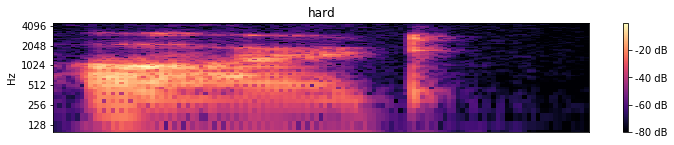

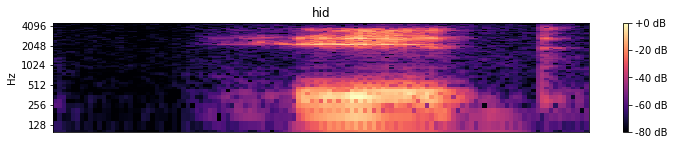

In [7]:
for fileidx in [1,5]:

    x_1, sr = librosa.load(basedir+phonemefilenames[fileidx],offset=.1, duration=.7)
    plt.figure(figsize=(12, 2))
    D1 = librosa.amplitude_to_db(np.abs(librosa.stft(x_1,n_fft=512)),  ref=np.max)
    librosa.display.specshow(D1, y_axis='log')
    plt.title(phonemenames[fileidx])
    plt.ylim(100,4500)
    plt.colorbar(format='%+2.0f dB')
    # If you want to look at the time domain signals:
    #     plt.figure(figsize=(12, 3))
    #     librosa.display.waveplot(x_1, sr=fs, color='gray')


In [8]:
ipd.Audio(x_1, rate=sr)

## Computing the spectrum and extracting F1, F2

* We will use `fftpack.fft` to get the frequency spectrum components for the files. `fftpack.fftfreq` gives us the frequencies associated with the intensities.
* We do not need to process the entire file. the files all start with a short silence and duration of 0.5 s will suffice.
* We will use plotSpectum to save the plots into a `plots` sub directory.
* We will take the lists we create, transpose them from rows to columns and put them into a data frame.
* Using the rough approximation from the graph we introduced in the lecture, we make the assumption that $250 \leq F1 \leq 650$ and $650 \leq F2 \leq 2600$.
* So, using the librosa peakfinder `librosa.util.peak_pick` we will find the peaks in the F1 and F2 ranges.
* Save these into the dataframe we created earlier and save that to a csv file.


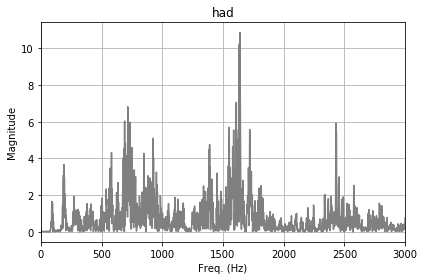

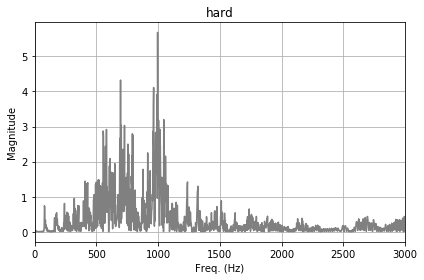

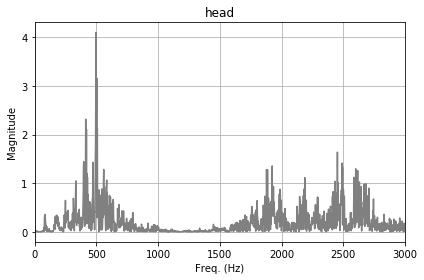

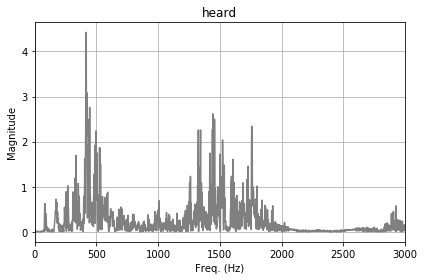

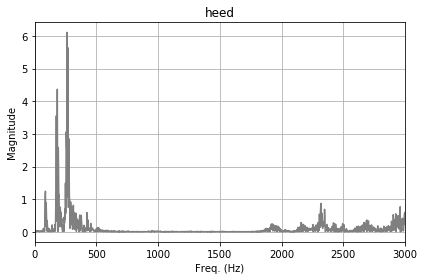

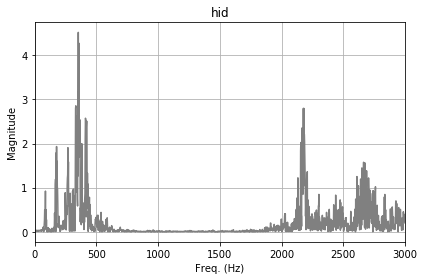

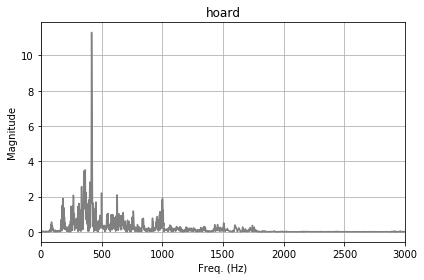

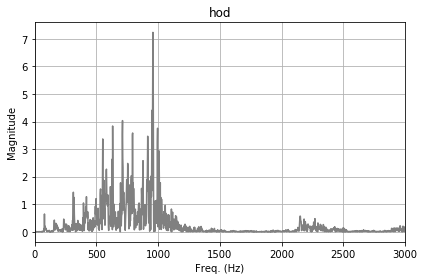

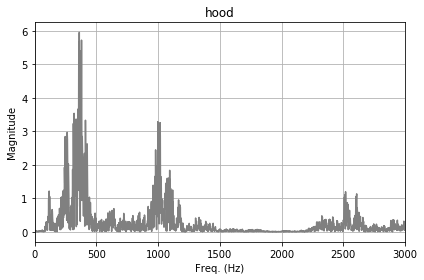

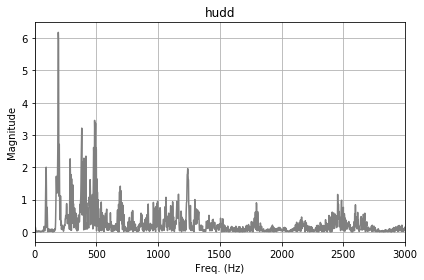

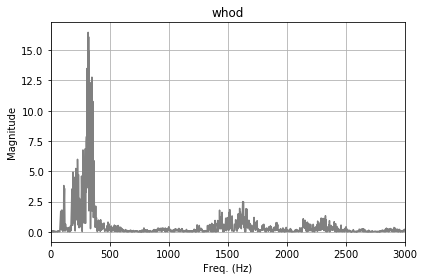

In [9]:
try:
    os.mkdir('plots')
except OSError:
    print('plots directory already exists')


for idx,fname in enumerate(phonemefilenames):
    formants
    x_1, fs = librosa.load(basedir+fname,duration=0.5, offset=.1)


    X = fftpack.fft(x_1) #get the FFT intensities
    freq=fftpack.fftfreq(len(x_1))*fs # get the corresponding freqencies
    freqidx=int(len(freq)/2) # ignore the negitive mirror image of fft 
    freq=freq[1:freqidx] # get the freqs
    mag=np.abs(X.real) # that the real absolute magnitudes
    mag=mag[1:freqidx] # for the positive freqs

    plotSpectrum(freq,mag,phonemenames[idx])

    #use librosa pick utility to find peaks
    indexes = librosa.util.peak_pick(mag, 3, 3, 3, 5, 0.1, 1) 

    peaks=[freq[indexes],mag[indexes]]

    
    peaksdf=pd.DataFrame(peaks).T
    peaksdf.columns=['freq','mag']
    
    # find the first and second formant:
    # first formant is max peak between ~ 250 and  650 Hz
    # second formant is max peak between ~ 650 and 2600 Hz

    fmin = 250
    f1max=650
    f2max=3000    
    peaksdf=pd.DataFrame(peaks).T # Create a dataframe and transpose rows to cols
    peaksdf.columns=['freq','mag']    # label them
    f1peaks=peaksdf[peaksdf.freq.between(fmin,f1max)] #get the frequencies in formant 1 freq range
    f1=f1peaks['freq'][f1peaks['mag'].idxmax()] #get the freq for the index of the max amp in this range
    

    
    f2peaks=peaksdf[peaksdf.freq.between(f1max,f2max)] #get the frequencies in formant 1 freq range
    f2=f2peaks['freq'][f2peaks['mag'].idxmax()] #get the freq for the index of the max amp in this range
    

    formants[0].append(f1)
    formants[1].append(f2)

    
dfformants['f1']=formants[0]
dfformants['f2']=formants[1]


dfformants.to_csv('speakerformants.csv')

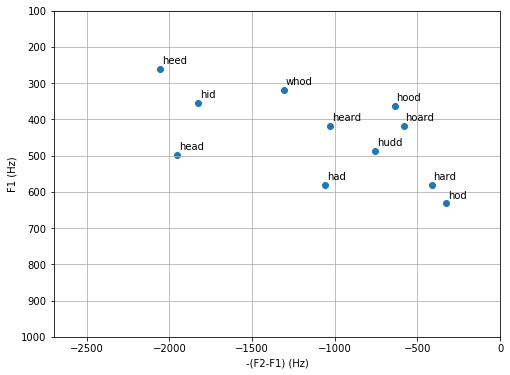

In [9]:
fig1=plt.figure(figsize=(8, 6))
ax2=fig1.add_subplot(111)
plt.scatter(-(dfformants['f2']-dfformants['f1']),dfformants['f1'])

for idx, phonemename in enumerate(phonemenames):
    ax2.annotate(phonemename,  xy=(-(formants[1][idx]-formants[0][idx])+10,formants[0][idx]-15))

#plt.grid('both')
plt.xlim((-2700, 0))
plt.ylim((1000, 100))
plt.grid(axis='both')
plt.xlabel('-(F2-F1) (Hz)')
plt.ylabel('F1 (Hz)')

plt.savefig('plots/vowelf1f2male453353.png')
plt.show()

In [10]:
dfformants

,speaker,word,f1,f2
0,453353,had,582.0,1640.0
1,453353,hard,582.0,996.0
2,453353,head,498.0,2452.0
3,453353,heard,418.0,1444.0
4,453353,heed,262.0,2318.0
5,453353,hid,354.0,2180.0
6,453353,hoard,418.0,1002.0
7,453353,hod,632.0,958.0
8,453353,hood,362.0,998.0
9,453353,hudd,486.0,1240.0


## Exercises

1. Record yourself saying the 10 words leaving a pause between each word. 
2. Using Audacity break it up into 10 wav files and save them as 16 bit mono wav recordings.
3. Choose a random 6 digit code as the speaker ID and save the files as `<speakerid>-<phonemename>.wav`
4. Repeat the exercise (incrementing the random number by 1
5. Plot all the results
6. Compare to the examples give and any other files (e.g. generated by a speech synthesizer, or  and examine and comment the how the different voices impact the results.
    * Do the points for the multiple utterances of the same word with your voice cluster together?
    * Do the points for the utterances of the same word with different people cluster together?
    * Are other people's samples clustered with yours?
7. Plot F1 vs F2.
8. Why do we plot F1 vs -(F2-F1) instead of F1 vs F2?

Upload your notebook to Brightspace.

Not required but, if you are willing to share you wav files, create a zip containing them and upload them too.